In [1]:
import numpy as np
import torch
import pandas as pd
import time
import operator
import statsmodels.api as sm
import matplotlib.pyplot as plt
from datetime import datetime
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
# from sklearn.preprocessing import StandardScaler
CONVERSION_MAP = {0:'00',1:'01',2:'02',3:'03',4:'04',5:'05',6:'06',7:'07',8:'08',9:'09'}
start_time = time.time()
research_date = range(1,13)
bitmex_maker = -0.00025
bitmex_taker = 0.00075
okex_maker = -0.0001
okex_taker = 0.0002

In [2]:
## PC =1 Q = 100

In [3]:
list1 = []
list2 = []
for date in research_date:
    date_str = CONVERSION_MAP[date] if date in CONVERSION_MAP else str(date)
    list1.append(pd.read_csv(r'C:\Users\wei\Desktop\python\PC\Depth_201909'+date_str+'_btc_usd.csv',index_col ='LastUpdateId', usecols = ['BidsPrice1', 'AsksPrice1','LastUpdateId','AsksQuantity1','BidsQuantity1']))
    list2.append(pd.read_csv(r'C:\Users\wei\Desktop\python\Q\Depth_201909'+date_str+'_btc_usd.csv',index_col ='LastUpdateId', usecols =['BidsPrice1', 'AsksPrice1','LastUpdateId','AsksQuantity1','BidsQuantity1']))

excel_file_input1 = pd.concat(list1)
excel_file_input2 = pd.concat(list2)
excel_file_input3 = pd.read_csv('Funding History  2019-10-30.csv', usecols = ['symbol', 'fundingRate', 'timestamp'])

In [4]:
excel_file_input3['timestamp'] = [datetime.strptime(i,'%Y-%m-%dT%H:%M:%S.%fZ').timestamp() for i in excel_file_input3['timestamp']]
excel_file_input3['funding_timestamp'] = excel_file_input3['timestamp'].astype(int)
excel_file_input3['timestamp'] = excel_file_input3['timestamp'].astype(int)-8*60*60
excel_file_input3.drop(excel_file_input3[excel_file_input3['symbol'] != 'XBTUSD' ].index, inplace=True)
excel_file_input3 = excel_file_input3.drop(['symbol'], axis =1)
excel_file_input3 = excel_file_input3.set_index('timestamp')

excel_file_input1.index = (excel_file_input1.index/1000).astype(int)
excel_file_input2.index = (excel_file_input2.index/1000).astype(int)
excel_file_input1=excel_file_input1.reset_index().drop_duplicates(subset='LastUpdateId', keep='first').set_index('LastUpdateId')
excel_file_input2=excel_file_input2.reset_index().drop_duplicates(subset='LastUpdateId', keep='first').set_index('LastUpdateId')

excel_file_input1 = excel_file_input1.rename(columns={"BidsPrice1": "bid_price_bitmex", "AsksPrice1": "ask_price_bitmex",'AsksQuantity1':'bitmex_askquantity1','BidsQuantity1':'bitmex_bidquantity1'})
excel_file_input2 = excel_file_input2.rename(columns={"BidsPrice1": "bid_price_okex", "AsksPrice1": 'ask_price_okex','AsksQuantity1':'okex_askquantity1','BidsQuantity1':'okex_bidquantity1'})
excel_file_input2['contract_exp'] = (1569571200 - excel_file_input2.index)

final_input = pd.merge(excel_file_input1, excel_file_input2, left_index = True, right_index = True, how='outer')
final_input = final_input.join(excel_file_input3)

for item in final_input.columns:
    final_input[item] = final_input[item].interpolate(method='pad')
final_input['funding_exp'] = final_input['funding_timestamp']-final_input.index
final_input = final_input.drop(['funding_timestamp'], axis =1)
final_input = final_input.dropna()

In [5]:
final_input['mid_spread'] = (final_input['bid_price_okex']+final_input['ask_price_okex'])/2-(final_input['bid_price_bitmex']+final_input['ask_price_bitmex'])/2
final_input['mid_spread_ma'] = final_input['mid_spread'].rolling(window=12*60*60).mean()
final_input['mid_spread_diff'] = final_input['mid_spread']-final_input['mid_spread_ma']
final_input['mid_spread_std'] = final_input['mid_spread_diff'].rolling(window=24*60*60).std()
final_input['mid_spread_zscore'] = final_input['mid_spread_diff']/final_input['mid_spread_std']

final_input['signal'] = 0
final_input['signal'][final_input['mid_spread_zscore'] > 1] = -0.01
final_input['signal'][final_input['mid_spread_zscore'] < -1] = 0.01

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [6]:
final_input.head()

,bid_price_bitmex,bitmex_bidquantity1,ask_price_bitmex,bitmex_askquantity1,bid_price_okex,okex_bidquantity1,ask_price_okex,okex_askquantity1,contract_exp,fundingRate,funding_exp,mid_spread,mid_spread_ma,mid_spread_diff,mid_spread_std,mid_spread_zscore,signal
LastUpdateId,,,,,,,,,,,,,,,,,
1567339200,9585.0,298019.0,9585.5,1350096.0,9634.83,601.0,9634.84,155.0,2232000.0,0.0001,28800.0,49.585,NaN,NaN,NaN,NaN,0.0
1567339201,9585.0,298019.0,9585.5,1350096.0,9634.83,579.0,9634.84,155.0,2231999.0,0.0001,28799.0,49.585,NaN,NaN,NaN,NaN,0.0
1567339202,9585.0,298019.0,9585.5,1350096.0,9634.83,533.0,9634.84,166.0,2231998.0,0.0001,28798.0,49.585,NaN,NaN,NaN,NaN,0.0
1567339203,9585.0,298019.0,9585.5,1350096.0,9634.83,265.0,9634.84,590.0,2231997.0,0.0001,28797.0,49.585,NaN,NaN,NaN,NaN,0.0
1567339204,9585.0,298019.0,9585.5,1350096.0,9634.83,215.0,9634.84,607.0,2231996.0,0.0001,28796.0,49.585,NaN,NaN,NaN,NaN,0.0


In [7]:
final_input['bitmex_bid_volum'] = final_input['bitmex_bidquantity1']/final_input['bid_price_bitmex']
final_input['bitmex_ask_volum'] = final_input['bitmex_askquantity1']/final_input['ask_price_bitmex']

In [8]:
final_input['okex_bid_volum'] = final_input['okex_bidquantity1']*100/final_input['bid_price_okex']
final_input['okex_ask_volum'] = final_input['okex_askquantity1']*100/final_input['ask_price_okex']

In [9]:
final_input.head(5)

,bid_price_bitmex,bitmex_bidquantity1,ask_price_bitmex,bitmex_askquantity1,bid_price_okex,okex_bidquantity1,ask_price_okex,okex_askquantity1,contract_exp,fundingRate,...,mid_spread,mid_spread_ma,mid_spread_diff,mid_spread_std,mid_spread_zscore,signal,bitmex_bid_volum,bitmex_ask_volum,okex_bid_volum,okex_ask_volum
LastUpdateId,,,,,,,,,,,,,,,,,,,,,
1567339200,9585.0,298019.0,9585.5,1350096.0,9634.83,601.0,9634.84,155.0,2232000.0,0.0001,...,49.585,NaN,NaN,NaN,NaN,0.0,31.092227,140.847739,6.237785,1.608745
1567339201,9585.0,298019.0,9585.5,1350096.0,9634.83,579.0,9634.84,155.0,2231999.0,0.0001,...,49.585,NaN,NaN,NaN,NaN,0.0,31.092227,140.847739,6.009447,1.608745
1567339202,9585.0,298019.0,9585.5,1350096.0,9634.83,533.0,9634.84,166.0,2231998.0,0.0001,...,49.585,NaN,NaN,NaN,NaN,0.0,31.092227,140.847739,5.532013,1.722914
1567339203,9585.0,298019.0,9585.5,1350096.0,9634.83,265.0,9634.84,590.0,2231997.0,0.0001,...,49.585,NaN,NaN,NaN,NaN,0.0,31.092227,140.847739,2.750438,6.123610
1567339204,9585.0,298019.0,9585.5,1350096.0,9634.83,215.0,9634.84,607.0,2231996.0,0.0001,...,49.585,NaN,NaN,NaN,NaN,0.0,31.092227,140.847739,2.231487,6.300053


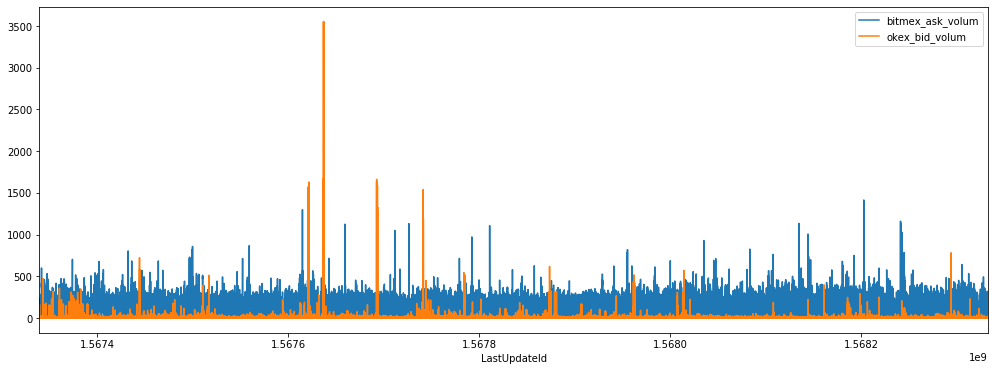

In [10]:
final_input[['bitmex_ask_volum','okex_bid_volum']].dropna().plot(figsize=(17, 6))

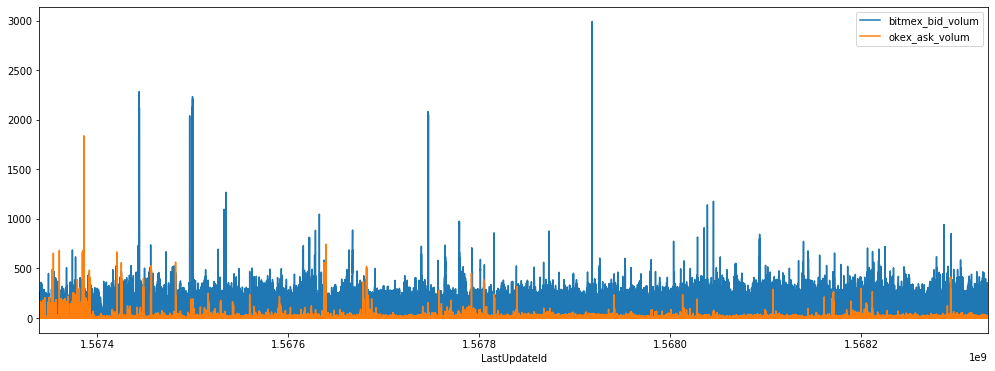

In [11]:
final_input[['bitmex_bid_volum','okex_ask_volum']].dropna().plot(figsize=(17, 6))

In [12]:
final_input.columns

Index(['bid_price_bitmex', 'bitmex_bidquantity1', 'ask_price_bitmex',
       'bitmex_askquantity1', 'bid_price_okex', 'okex_bidquantity1',
       'ask_price_okex', 'okex_askquantity1', 'contract_exp', 'fundingRate',
       'funding_exp', 'mid_spread', 'mid_spread_ma', 'mid_spread_diff',
       'mid_spread_std', 'mid_spread_zscore', 'signal', 'bitmex_bid_volum',
       'bitmex_ask_volum', 'okex_bid_volum', 'okex_ask_volum'],
      dtype='object')

In [13]:
test = pd.DataFrame(final_input['bid_price_bitmex'])

In [14]:
test['bitmex_bid_volum'] = final_input['bitmex_bid_volum']

In [15]:
test['ask_price_okex'] = final_input['ask_price_okex']
test['okex_ask_volum'] = final_input['okex_ask_volum']
test['ask_price_bitmex'] = final_input['ask_price_bitmex']
test['bitmex_ask_volum'] = final_input['bitmex_ask_volum']
test['bid_price_okex'] = final_input['bid_price_okex']
test['okex_bid_volum'] = final_input['okex_bid_volum']
test['signal'] = final_input['signal']

In [16]:
test.head()

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal
LastUpdateId,,,,,,,,,
1567339200,9585.0,31.092227,9634.84,1.608745,9585.5,140.847739,9634.83,6.237785,0.0
1567339201,9585.0,31.092227,9634.84,1.608745,9585.5,140.847739,9634.83,6.009447,0.0
1567339202,9585.0,31.092227,9634.84,1.722914,9585.5,140.847739,9634.83,5.532013,0.0
1567339203,9585.0,31.092227,9634.84,6.123610,9585.5,140.847739,9634.83,2.750438,0.0
1567339204,9585.0,31.092227,9634.84,6.300053,9585.5,140.847739,9634.83,2.231487,0.0


In [18]:
#test['last_signal'] = test['signal'].shift(1)
test['last_bid_price_bitmex'] = test['bid_price_bitmex'].shift(1)
test['last_ask_price_bitmex'] = test['ask_price_bitmex'].shift(1)
test[test['signal'] != 0][500:550]

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal,last_bid_price_bitmex,last_ask_price_bitmex
LastUpdateId,,,,,,,,,,,
1567471303,10399.5,142.684071,10458.01,3.346717,10400.0,57.880096,10458.00,0.239051,-0.01,10399.5,10400.0
1567471304,10399.5,140.758210,10458.01,3.222410,10400.0,60.764712,10458.00,0.239051,-0.01,10399.5,10400.0
1567471305,10399.5,140.758210,10458.01,2.161023,10400.0,60.764712,10458.00,0.382482,-0.01,10399.5,10400.0
1567471306,10399.5,140.758210,10458.01,2.151461,10400.0,60.764712,10458.00,0.286862,-0.01,10399.5,10400.0
1567471307,10399.5,140.753786,10458.01,3.786571,10400.0,60.774615,10458.00,0.286862,-0.01,10399.5,10400.0
1567471308,10399.5,138.329824,10457.91,3.767483,10400.0,58.512019,10457.90,0.076497,-0.01,10399.5,10400.0
1567471309,10399.5,139.868359,10457.91,5.899840,10400.0,72.935096,10457.90,0.086059,-0.01,10399.5,10400.0
1567471310,10399.5,117.100918,10457.91,4.264714,10400.0,105.101635,10457.90,0.086059,-0.01,10399.5,10400.0
1567471311,10399.5,115.560075,10457.91,3.098133,10400.0,105.101635,10457.90,0.152994,-0.01,10399.5,10400.0


In [20]:
test['true signal-0.01'] = np.where((test['bid_price_bitmex'] < test['last_bid_price_bitmex']) & (test['signal']==-0.01) , -0.01,0)
test[test['true signal-0.01']== -0.01].head(50)

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal,last_bid_price_bitmex,last_ask_price_bitmex,true signal-0.01
LastUpdateId,,,,,,,,,,,,
1567470891,10409.0,27.351138,10471.56,2.425618,10409.5,108.009895,10471.55,0.611180,-0.01,10420.0,10420.5,-0.01
1567471043,10401.0,21.020575,10458.64,3.289147,10401.5,118.818920,10458.63,2.256510,-0.01,10403.0,10403.5,-0.01
1567471885,10411.0,27.954375,10468.79,0.582684,10411.5,76.472650,10468.78,2.130143,-0.01,10418.0,10418.5,-0.01
1567471972,10409.0,1.488231,10466.71,23.856589,10409.5,183.280753,10466.70,8.426725,-0.01,10409.5,10410.0,-0.01
1567471983,10408.0,6.362702,10466.71,21.936215,10408.5,193.944468,10466.70,2.971328,-0.01,10409.0,10409.5,-0.01
1567471986,10407.0,25.702220,10466.71,21.773795,10407.5,156.772616,10466.70,1.891714,-0.01,10408.0,10408.5,-0.01
1567472481,10409.5,0.592824,10467.99,1.184564,10410.0,173.786359,10467.98,0.382118,-0.01,10410.5,10411.0,-0.01
1567472490,10408.0,3.877402,10467.98,7.594588,10408.5,119.750877,10467.97,0.343906,-0.01,10409.5,10410.0,-0.01
1567472510,10405.0,1.936665,10463.59,1.433542,10405.5,174.400077,10463.58,2.456138,-0.01,10406.0,10406.5,-0.01


In [21]:
test[test.index > 1567472884].head(20)

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal,last_bid_price_bitmex,last_ask_price_bitmex,true signal-0.01
LastUpdateId,,,,,,,,,,,,
1567472885,10394.5,21.229208,10454.17,2.104423,10395.0,225.055604,10454.16,0.602631,-0.01,10395.0,10395.5,-0.01
1567472886,10394.5,19.832989,10454.17,2.133120,10395.0,230.611929,10454.16,0.660024,-0.01,10394.5,10395.0,0.00
1567472887,10394.5,19.852422,10454.17,2.563570,10395.0,225.883790,10454.16,0.506975,-0.01,10394.5,10395.0,0.00
1567472888,10394.0,1.523186,10454.17,2.362694,10394.5,6.052047,10454.16,0.899164,-0.01,10394.5,10395.0,-0.01
1567472889,10392.0,16.956794,10454.17,2.793144,10392.5,65.636854,10454.16,0.506975,-0.01,10394.0,10394.5,-0.01
1567472890,10392.0,31.373845,10454.17,2.582701,10392.5,168.574934,10454.16,0.449582,-0.01,10392.0,10392.5,0.00
1567472891,10392.0,32.311393,10450.00,1.416268,10392.5,138.522973,10449.99,0.382775,-0.01,10392.0,10392.5,0.00
1567472892,10392.0,21.981332,10453.39,0.047831,10392.5,152.850613,10453.16,0.640955,-0.01,10392.0,10392.5,0.00
1567472893,10392.0,18.716320,10453.25,2.286370,10392.5,160.291364,10453.24,0.344391,-0.01,10392.0,10392.5,0.00


In [22]:
test['last_okex_ask_volum'] = test['okex_ask_volum'].shift(1)

In [23]:
test[test.index > 1567472884].head(20)

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal,last_bid_price_bitmex,last_ask_price_bitmex,true signal-0.01,last_okex_ask_volum
LastUpdateId,,,,,,,,,,,,,
1567472885,10394.5,21.229208,10454.17,2.104423,10395.0,225.055604,10454.16,0.602631,-0.01,10395.0,10395.5,-0.01,2.104423
1567472886,10394.5,19.832989,10454.17,2.133120,10395.0,230.611929,10454.16,0.660024,-0.01,10394.5,10395.0,0.00,2.104423
1567472887,10394.5,19.852422,10454.17,2.563570,10395.0,225.883790,10454.16,0.506975,-0.01,10394.5,10395.0,0.00,2.133120
1567472888,10394.0,1.523186,10454.17,2.362694,10394.5,6.052047,10454.16,0.899164,-0.01,10394.5,10395.0,-0.01,2.563570
1567472889,10392.0,16.956794,10454.17,2.793144,10392.5,65.636854,10454.16,0.506975,-0.01,10394.0,10394.5,-0.01,2.362694
1567472890,10392.0,31.373845,10454.17,2.582701,10392.5,168.574934,10454.16,0.449582,-0.01,10392.0,10392.5,0.00,2.793144
1567472891,10392.0,32.311393,10450.00,1.416268,10392.5,138.522973,10449.99,0.382775,-0.01,10392.0,10392.5,0.00,2.582701
1567472892,10392.0,21.981332,10453.39,0.047831,10392.5,152.850613,10453.16,0.640955,-0.01,10392.0,10392.5,0.00,1.416268
1567472893,10392.0,18.716320,10453.25,2.286370,10392.5,160.291364,10453.24,0.344391,-0.01,10392.0,10392.5,0.00,0.047831


In [31]:
bitmex_bid = test[test['true signal-0.01']==-0.01]['last_okex_ask_volum'].sum()
bitmex_bid

22179.037373826588

In [25]:
test['true signal+0.01'] = np.where((test['ask_price_bitmex'] > test['last_ask_price_bitmex']) & (test['signal']==0.01), 0.01,0)
test[test['true signal+0.01']== 0.01].head()

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal,last_bid_price_bitmex,last_ask_price_bitmex,true signal-0.01,last_okex_ask_volum,true signal+0.01
LastUpdateId,,,,,,,,,,,,,,
1567478996,10416.0,1.851863,10463.09,0.382296,10420.5,31.224221,10462.66,0.019116,0.01,10416.0,10416.5,0.0,4.797529,0.01
1567481786,10509.5,4.322185,10555.00,310.165798,10510.0,1.774500,10554.99,13.737578,0.01,10502.5,10503.0,0.0,374.078636,0.01
1567481788,10510.0,19.666508,10555.00,24.272856,10510.5,3.451786,10554.99,25.779276,0.01,10509.5,10510.0,0.0,155.490289,0.01
1567481793,10526.5,1.899967,10565.70,7.808285,10527.0,8.313575,10565.00,0.208235,0.01,10520.5,10521.5,0.0,0.728482,0.01
1567481794,10527.5,29.398433,10562.73,0.435493,10528.0,23.326748,10562.72,0.113607,0.01,10526.5,10527.0,0.0,7.808285,0.01


In [27]:
test['last_okex_bid_volum'] = test['okex_bid_volum'].shift(1)

In [28]:
test[test.index > 1567481780].head(20)

,bid_price_bitmex,bitmex_bid_volum,ask_price_okex,okex_ask_volum,ask_price_bitmex,bitmex_ask_volum,bid_price_okex,okex_bid_volum,signal,last_bid_price_bitmex,last_ask_price_bitmex,true signal-0.01,last_okex_ask_volum,true signal+0.01,last_okex_bid_volum
LastUpdateId,,,,,,,,,,,,,,,
1567481781,10487.0,16.598646,10555.00,563.742302,10495.5,9.342861,10554.99,0.738987,-0.01,10483.5,10484.0,0.0,1.402736,0.00,1.611252
1567481782,10496.5,9.515076,10555.00,503.022264,10497.0,9.949319,10554.99,0.378968,0.00,10487.0,10495.5,0.0,563.742302,0.00,0.738987
1567481783,10498.0,8.832159,10555.00,482.055898,10498.5,0.069343,10554.99,0.056845,0.00,10496.5,10497.0,0.0,503.022264,0.00,0.378968
1567481784,10499.0,2.857415,10555.00,407.721459,10499.5,0.036002,10554.99,4.973951,0.00,10498.0,10498.5,0.0,482.055898,0.00,0.056845
1567481785,10502.5,0.567579,10555.00,374.078636,10503.0,0.952109,10554.99,5.722412,0.00,10499.0,10499.5,0.0,407.721459,0.00,4.973951
1567481786,10509.5,4.322185,10555.00,310.165798,10510.0,1.774500,10554.99,13.737578,0.01,10502.5,10503.0,0.0,374.078636,0.01,5.722412
1567481787,10509.5,10.326276,10555.00,155.490289,10510.0,0.967364,10554.99,18.105181,0.01,10509.5,10510.0,0.0,310.165798,0.00,13.737578
1567481788,10510.0,19.666508,10555.00,24.272856,10510.5,3.451786,10554.99,25.779276,0.01,10509.5,10510.0,0.0,155.490289,0.01,18.105181
1567481789,10510.0,40.268030,10567.64,0.094629,10510.5,31.305456,10565.00,0.482726,0.00,10510.0,10510.5,0.0,24.272856,0.00,25.779276


In [32]:
bitmex_ask = test[test['true signal+0.01']== 0.01]['last_okex_bid_volum'].sum()
bitmex_ask

11695.200996798925

In [33]:
bitmex_bid + bitmex_ask #做市

33874.23837062551